In [124]:
import sys
import os

from typing import Dict
import numpy as np
from numpy import linalg
import scipy
from scipy import stats
from scipy.stats import pearsonr
from sklearn.utils.extmath import randomized_svd
from typing import List
from tqdm import tqdm
import random
import warnings
import sklearn
import time

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, Counter
from sklearn.manifold import TSNE
import copy
from sklearn.svm import LinearSVC

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from torch.optim import SGD, Adam
from sklearn.svm import LinearSVC

import pickle
import matplotlib.pyplot as plt
from sklearn import cluster, neural_network
from sklearn.neural_network import MLPClassifier
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import warnings

In [55]:
random.seed(0)
np.random.seed(0)

class Args():
    
    model_type='bert'
    device=-1
    run_id=1
    do_inlp=1
    do_rlace=1
    ranks="[1,4,8,16,32,50,64,100]"
    pickle_file_train='gender_data_for_inlp_train.pickle'
    pickle_file_dev='gender_data_for_inlp_dev.pickle'
    
args=Args()
ranks=eval(args.ranks)

In [72]:
#Abstract class for linear classifiers
class Classifier(object):
    
    def __init__(self):
        
        pass
    
    def train(self, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray,
             Y_dev: np.ndarray) -> float:
        """
        :return: accuracy score on the dev set
        """
        raise NotImplementedError
        
    def get_weights(self) -> np.ndarray:
        """ 
        :return: final weights of the model, as np array
        """
        raise NotImplementedError
        
    
class CovMaximizer(object):
    
    def __init__(self):
        
        pass
    
    def fit(self, X_train: np.ndarray, Y_train: np.ndarray) -> float:
        """
        :return: accuracy score on the dev set
        """
        
        eigvals, eigvecs = np.linalg.eigh((1./len(X_train)**2)*X_train.T@Y_train@Y_train.T@X_train)
        """
        U, Sigma, VT = randomized_svd((1/np.sqrt(len(X_train)))*cov,
                              n_components=2,
                              n_iter=15,
                              random_state=None)
        """
        self.w = eigvecs[:,-1]
        self.coef_ = self.w
        print(self.w.shape)
        
    def score(self, X_dev, Y_dev):
    
        
        cov = (1./len(X_dev)**2) * (X_dev.T@Y_dev@Y_dev.T@X_dev)
        return self.w.T@cov.T@cov@self.w
        
    def get_weights(self) -> np.ndarray:
        """
        :return: final weights of the model, as np array
        """

        return self.w
    
class SKlearnClassifier(Classifier):

    def __init__(self, m):

        self.model = m

    def train_network(self, X_train: np.ndarray, Y_train: np.ndarray, X_dev: np.ndarray, Y_dev: np.ndarray) -> float:

        """
        :return: accuracy score on the dev set / Person's R in the case of regression
        """

        self.model.fit(X_train, Y_train)
        score = self.model.score(X_dev, Y_dev)
        return score

    def get_weights(self) -> np.ndarray:
        """
        :return: final weights of the model, as np array
        """

        w = self.model.coef_
        if len(w.shape) == 1:
                w = np.expand_dims(w, 0)

        return w

In [105]:
def get_debiasing_projection(classifier_class, cls_params: Dict, num_classifiers: int, input_dim: int,
                            is_autoregressive: bool, min_accuracy: float, X_train: np.ndarray,
                            Y_train: np.ndarray, X_dev: np.ndarray, Y_dev: np.ndarray, by_class=True,
                            Y_train_main=None, Y_dev_main=None, dropout_rate=0) -> np.ndarray:
    """
    :param classifier_class: the sklearn classifier class (SVM/Perceptron etc.)
    :param cls_params: a dictionary, containing the params for the sklearn classifier
    :param num_classifiers: number of iterations (equivalent to number of dimensions to remove)
    :param input_dim: size of input vectors
    :param is_autoregressive: whether to train the ith classiifer on the data projected to the nullsapces of w1,...,wi-1
    :param min_accuracy: above this threshold, ignore the learned classifier
    :param X_train: ndarray, training vectors
    :param Y_train: ndarray, training labels (protected attributes)
    :param X_dev: ndarray, eval vectors
    :param Y_dev: ndarray, eval labels (protected attributes)
    :param by_class: if true, at each iteration sample one main-task label, and extract the protected attribute only from vectors from this class
    :param T_train_main: ndarray, main-task train labels
    :param Y_dev_main: ndarray, main-task eval labels
    :param dropout_rate: float, default: 0 (note: not recommended to be used with autoregressive=True)
    :return: P, the debiasing projection; rowspace_projections, the list of all rowspace projection; Ws, the list of all calssifiers.
    """
    if dropout_rate > 0 and is_autoregressive:
        warnings.warn("Note: when using dropout with autoregressive training, the property w_i.dot(w_(i+1)) = 0 no longer holds.")

    I = np.eye(input_dim)

    if by_class:
        if ((Y_train_main is None) or (Y_dev_main is None)):
            raise Exception("Need main-task labels for by-class training.")
        main_task_labels = list(set(Y_train_main.tolist()))

    X_train_cp = X_train.copy()
    X_dev_cp = X_dev.copy()
    Y_train_cp = Y_train.copy()
    Y_dev_cp = Y_dev.copy()
    
    rowspace_projections = []
    Ws = []
    accs = []
    
    pbar = tqdm(range(num_classifiers))
    for i in pbar:

        clf = SKlearnClassifier(classifier_class(**cls_params))
        dropout_scale = 1./(1 - dropout_rate + 1e-6)
        dropout_mask = (np.random.rand(*X_train.shape) < (1-dropout_rate)).astype(float) * dropout_scale


        if by_class:
            #cls = np.random.choice(Y_train_main)  # uncomment for frequency-based sampling
            cls = random.choice(main_task_labels)
            relevant_idx_train = Y_train_main == cls
            relevant_idx_dev = Y_dev_main == cls
        else:
            relevant_idx_train = np.ones(X_train_cp.shape[0], dtype=bool)
            relevant_idx_dev = np.ones(X_dev_cp.shape[0], dtype=bool)

        acc = clf.train_network((X_train_cp * dropout_mask)[relevant_idx_train], Y_train_cp[relevant_idx_train], X_dev_cp[relevant_idx_dev], Y_dev_cp[relevant_idx_dev])
        pbar.set_description("iteration: {}, accuracy: {}".format(i, acc))
        accs.append(acc)
        if acc < min_accuracy: continue

        W = clf.get_weights()
        #W[0][-10:] = 0.0
        
        Ws.append(W)
        P_rowspace_wi = get_rowspace_projection(W) # projection to W's rowspace
        rowspace_projections.append(P_rowspace_wi)

        if is_autoregressive:

            """
            to ensure numerical stability, explicitly project to the intersection of the nullspaces found so far (instaed of doing X = P_iX,
            which is problematic when w_i is not exactly orthogonal to w_i-1,...,w1, due to e.g inexact argmin calculation).
            """
            # use the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
            # N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))

            P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)
            # project



            #Y_train_cp = Y_train_cp - (X_train_cp@W.T).squeeze()
            #Y_dev_cp = Y_dev_cp - (X_dev_cp@W.T).squeeze()
            
            X_train_cp = (P.dot(X_train.T)).T
            X_dev_cp = (P.dot(X_dev.T)).T
         
            

    """
    calculate final projection matrix P=PnPn-1....P2P1
    since w_i.dot(w_i-1) = 0, P2P1 = I - P1 - P2 (proof in the paper); this is more stable.
    by induction, PnPn-1....P2P1 = I - (P1+..+PN). We will use instead Ben-Israel's formula to increase stability and also generalize to the non-orthogonal case (e.g. with dropout),
    i.e., we explicitly project to intersection of all nullspaces (this is not critical at this point; I-(P1+...+PN) is roughly as accurate as this provided no dropout & regularization)
    """

    P = get_projection_to_intersection_of_nullspaces(rowspace_projections, input_dim)
    Ws = np.array(Ws).squeeze(1)
    Ws = Ws/np.linalg.norm(Ws, axis = 1, keepdims=True)
    
    return P, accs, Ws



def get_rowspace_projection(W:np.ndarray) -> np.ndarray:
    """
    :param W: the matrix over its nullspace to project
    :return: the projection matrix over the rowspace
    """

    
    if np.allclose(W, 0):
        w_basis = np.zeros_like(W.T)
    else:
        w_basis = scipy.linalg.orth(W.T) # orthogonal basis

    P_W = w_basis.dot(w_basis.T) # orthogonal projection on W's rowspace

    return P_W


def get_projection_to_intersection_of_nullspaces(rowspace_projection_matrices: List[np.ndarray], input_dim: int):
    """
    Given a list of rowspace projection matrices P_R(w_1), ..., P_R(w_n),
    this function calculates the projection to the intersection of all nullspasces of the matrices w_1, ..., w_n.
    uses the intersection-projection formula of Ben-Israel 2013 http://benisrael.net/BEN-ISRAEL-NOV-30-13.pdf:
    N(w1)∩ N(w2) ∩ ... ∩ N(wn) = N(P_R(w1) + P_R(w2) + ... + P_R(wn))
    :param rowspace_projection_matrices: List[np.array], a list of rowspace projections
    :param dim: input dim
    """

    I = np.eye(input_dim)
    Q = np.sum(rowspace_projection_matrices, axis = 0)
    P = I - get_rowspace_projection(Q)

    return P


def solve_adv_game(X_train, y_train, X_dev, y_dev, rank=1, device="cpu", out_iters=75000,
                  in_iters_adv=1, in_iters_clf=1,  epsilon=0.0015, batch_size=128, 
                   evalaute_every=1000, optimizer_class=SGD, 
                   optimizer_params_P={"lr": 0.005, "weight_decay": 1e-4}, 
                   optimizer_params_predictor={"lr": 0.005, "weight_decay": 1e-4}):
    """
    :param X: The input (np array)
    :param Y: the lables (np array)
    :param X_dev: Dev set (np array)
    :param Y_dev: Dev labels (np array)
    :param rank: Number of dimensions to neutralize from the input.
    :param device:
    :param out_iters: Number of batches to run
    :param in_iters_adv: number of iterations for adversary's optimization
    :param in_iters_clf: number of iterations from the predictor's optimization
    :param epsilon: stopping criterion .Stops if abs(acc - majority) < epsilon.
    :param batch_size:
    :param evalaute_every: After how many batches to evaluate the current adversary.
    :param optimizer_class: SGD/Adam etc.
    :param optimizer_params: the optimizer's params (as a dict)
    :return:
    """
    def get_loss_fn(X, y, predictor, P, bce_loss_fn, optimize_P=False):
        I = torch.eye(X_train.shape[1]).to(device)
        bce = bce_loss_fn(predictor(X @ (I - P)).squeeze(), y)
        if optimize_P:
            bce = -bce
        return bce


    X_torch = torch.tensor(X_train).float().to(device)
    y_torch = torch.tensor(y_train).float().to(device)

    num_labels = len(set(y_train.tolist()))
    if num_labels == 2:
        predictor = torch.nn.Linear(X_train.shape[1], 1).to(device)
        bce_loss_fn = torch.nn.BCEWithLogitsLoss()
        y_torch = y_torch.float()
    else:
        predictor = torch.nn.Linear(X_train.shape[1], num_labels).to(device)
        bce_loss_fn = torch.nn.CrossEntropyLoss()
        y_torch = y_torch.long()

    P = 1e-1*torch.randn(X_train.shape[1], X_train.shape[1]).to(device)
    P.requires_grad = True

    optimizer_predictor = optimizer_class(predictor.parameters(), **optimizer_params_predictor)
    optimizer_P = optimizer_class([P],**optimizer_params_P)

    maj = get_majority_acc(y_train)
    label_entropy = get_entropy(y_train)
    pbar = tqdm(range(out_iters), total = out_iters, ascii=True)
    count_examples = 0
    best_P, best_score, best_loss = None, 1, -1

    for i in pbar:

        for j in range(in_iters_adv):
            P = symmetric(P)
            optimizer_P.zero_grad()

            idx = np.arange(0, X_torch.shape[0])
            np.random.shuffle(idx)
            X_batch, y_batch = X_torch[idx[:batch_size]], y_torch[idx[:batch_size]]

            loss_P = get_loss_fn(X_batch, y_batch, predictor, symmetric(P), bce_loss_fn, optimize_P=True)
            loss_P.backward()
            optimizer_P.step()

            # project

            with torch.no_grad():
                D, U = torch.linalg.eigh(symmetric(P).detach().cpu())
                D = D.detach().cpu().numpy()
                D_plus_diag = solve_constraint(D, d=rank)
                D = torch.tensor(np.diag(D_plus_diag).real).float().to(device)
                U = U.to(device)
                P.data = U @ D @ U.T

        for j in range(in_iters_clf):
            optimizer_predictor.zero_grad()
            idx = np.arange(0, X_torch.shape[0])
            np.random.shuffle(idx)
            X_batch, y_batch = X_torch[idx[:batch_size]], y_torch[idx[:batch_size]]

            loss_predictor = get_loss_fn(X_batch, y_batch, predictor, symmetric(P), bce_loss_fn, optimize_P=False)
            loss_predictor.backward()
            optimizer_predictor.step()
            count_examples += batch_size

        if i % evalaute_every == 0:
            #pbar.set_description("Evaluating current adversary...")
            loss_val, score = get_score(X_train, y_train, X_train, y_train, P.detach().cpu().numpy(), rank)
            if loss_val > best_loss:#if np.abs(score - maj) < np.abs(best_score - maj):
                best_P, best_loss = symmetric(P).detach().cpu().numpy().copy(), loss_val
            if np.abs(score - maj) < np.abs(best_score - maj):
                best_score = score
                
            # update progress bar
            
            best_so_far = best_score if np.abs(best_score-maj) < np.abs(score-maj) else score
            
            pbar.set_description("{:.0f}/{:.0f}. Acc post-projection: {:.3f}%; best so-far: {:.3f}%; Maj: {:.3f}%; Gap: {:.3f}%; best loss: {:.4f}; current loss: {:.4f}".format(i, out_iters, score * 100, best_so_far * 100, maj * 100, np.abs(best_so_far - maj) * 100, best_loss, loss_val))
            pbar.refresh()  # to show immediately the update
            time.sleep(0.01)

        if i > 1 and np.abs(best_score - maj) < epsilon:
        #if i > 1 and np.abs(best_loss - label_entropy) < epsilon:
                    break
    output = prepare_output(best_P,rank,best_score)
    return output


def get_majority_acc(y):
    c = Counter(y)
    fracts = [v / sum(c.values()) for v in c.values()]
    maj = max(fracts)
    return maj


def get_entropy(y):
    c = Counter(y)
    fracts = [v / sum(c.values()) for v in c.values()]
    return scipy.stats.entropy(fracts)

def prepare_output(P,rank,score):
    P_final = get_projection(P,rank)
    return {"score": score, "P_before_svd": np.eye(P.shape[0]) - P, "P": P_final}


def solve_constraint(lambdas, d=1):
    def f(theta):
        return_val = np.sum(np.minimum(np.maximum(lambdas - theta, 0), 1)) - d
        return return_val

    theta_min, theta_max = max(lambdas), min(lambdas) - 1
    assert f(theta_min) * f(theta_max) < 0

    mid = (theta_min + theta_max) / 2
    tol = 1e-4
    iters = 0

    while iters < 25:

        mid = (theta_min + theta_max) / 2

        if f(mid) * f(theta_min) > 0:

            theta_min = mid
        else:
            theta_max = mid
        iters += 1

    lambdas_plus = np.minimum(np.maximum(lambdas - mid, 0), 1)
    # if (theta_min-theta_max)**2 > tol:
    #    print("didn't converge", (theta_min-theta_max)**2)
    return lambdas_plus

def get_score(X_train, y_train, X_dev, y_dev, P, rank):
    P_svd = get_projection(P, rank)
    
    loss_vals = []
    accs = []
    
    for i in range(NUM_CLFS_IN_EVAL):
        clf = init_classifier()
        clf.fit(X_train@P_svd, y_train)
        y_pred = clf.predict_proba(X_dev@P_svd)
        loss = sklearn.metrics.log_loss(y_dev, y_pred)
        loss_vals.append(loss)
        accs.append(clf.score(X_dev@P_svd, y_dev))
        
    i = np.argmin(loss_vals)
    return loss_vals[i], accs[i]


def init_classifier():

    return SGDClassifier(loss=EVAL_CLF_PARAMS["loss"], fit_intercept=True, max_iter=EVAL_CLF_PARAMS["max_iter"], tol=EVAL_CLF_PARAMS["tol"], n_iter_no_change=EVAL_CLF_PARAMS["iters_no_change"],
                        n_jobs=32, alpha=EVAL_CLF_PARAMS["alpha"])
                        
def symmetric(X):
    X.data = 0.5 * (X.data + X.data.T)
    return X

def get_projection(P, rank):
    D,U = np.linalg.eigh(P)
    U = U.T
    W = U[-rank:]
    P_final = np.eye(P.shape[0]) - W.T @ W
    return P_final

In [106]:
def set_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    
def load_data(args, file, seed=None):
    
    X=np.load("encodings/{}_{}.npy".format(args.model_type, file))
    
    #EXPAND WHEN ADDING ADDITIONAL BIAS DIRECTIONS
    with open(file, "rb") as f:
        data=pickle.load(f)
        Y=np.array([1 if d["g"]=="f" else 0 for d in data])
        stereotype=np.array([d["s"] for d in data])
        txts=[d["text"] for d in data]
        random.seed(0)
        np.random.seed(0)
        X, Y, stereotype, txts, data = sklearn.utils.shuffle(X,Y,stereotype,txts,data)
        X=X[:]
        Y=Y[:]
        
    return X,Y,txts,stereotype,data

In [107]:
def run_inlp(X, y, X_dev, y_dev, num_iters=25):
    clf=SGDClassifier
    LOSS="log"
    ALPHA = 1e-4
    TOL = 1e-4
    ITER_NO_CHANGE = 20
    params = {"loss": LOSS, "fit_intercept": True, "max_iter": 2000000, "tol": TOL, "n_iter_no_change": ITER_NO_CHANGE,
              "alpha": ALPHA, "n_jobs": 32}
    
    input_dim=X_dev.shape[1]
    
    P_inlp, accs_inlp, ws_inlp_normalized = get_debiasing_projection(clf, params, num_iters, X_dev.shape[1], True, -1,
                                                                     X, y, X_dev, y_dev, by_class=False,
                                                                     Y_train_main=None, Y_dev_main=None, dropout_rate=0)
    
    Ps_nullspace=[]
    for i in range(1, num_iters):
        P=np.eye(X.shape[1]) - (ws_inlp_normalized[:i]).T @ ws_inlp_normalized[:i]
        Ps_nullspace.append(P)
        
    for P, w in zip(Ps_nullspace, ws_inlp_normalized):
        assert np.allclose(X @ P @ w, np.zeros(X.shape[0]))

    return Ps_nullspace, ws_inlp_normalized, accs_inlp

In [76]:
def plot_pca(X, y, path, title, method="pca"):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.rcParams['font.family']='Serif'

        if method == "pca":
            pca = PCA(n_components=2)
            M = 6000
        elif method == "tsne":
            pca = TSNE(n_components=2, learning_rate="auto", init="pca")
            M = 1500

        X_proj = pca.fit_transform(X[:M])
        ax = plt.axes()
        ax.set_axisbelow(True)
        ax.yaxis.grid(color='gray', linestyle='dashed')
        ax.xaxis.grid(color='gray', linestyle='dashed')

        y_text = ["Female-biased" if yy == 1 else "Male-biased" for yy in y]
        plt1 = sn.scatterplot(X_proj[:, 0], X_proj[:, 1], hue=y_text[:M])
        plt.legend(fontsize=19)
        ax.set_title('{}'.format(title), fontsize=25)
        ax.figure.savefig("{}/{}.pdf".format(path, title), dpi=400)
        plt.clf()
        
def get_svd(X):
    D, U = np.linalg.eigh(X)
    return U, D

In [109]:
EVAL_CLF_PARAMS = {"loss": "log", "tol": 1e-4, "iters_no_change": 15, "alpha": 1e-4, "max_iter": 25000}
NUM_CLFS_IN_EVAL = 3 # change to 1 for large dataset / high dimensionality

rlace_projs=defaultdict(dict)
inlp_projs=defaultdict(dict)
device="cpu" if args.device==-1 else "cuda:{}".format(args.device)
DEVICE=device

X, y, txts, stereotypes, data=load_data(args, args.pickle_file_train)
if len(X)>=100000:
    X, y=X[:100000], y[:100000]
    
if not os.path.exists("pca"):
    os.makedirs("pca")
pca=PCA(random_state=args.run_id, n_components=300)
pca.fit(X)
with open("pca/pca_{}_{}.pickle".format(args.model_type, args.run_id), "wb") as f:
    pickle.dump(pca, f)
X=pca.transform(X)

X_dev, y_dev, txts_dev, stereotypes_dev, data_dev=load_data(args, args.pickle_file_dev)
X_dev=pca.transform(X_dev)

In [51]:
os.makedirs("plots/{}/original/pca".format(args.model_type), exist_ok=True)
os.makedirs("plots/{}/original/tsne".format(args.model_type), exist_ok=True)
os.makedirs("plots/{}/inlp/pca".format(args.model_type), exist_ok=True)
os.makedirs("plots/{}/inlp/tsne".format(args.model_type), exist_ok=True)
os.makedirs("plots/{}/rlace/pca".format(args.model_type), exist_ok=True)
os.makedirs("plots/{}/rlace/tsne".format(args.model_type), exist_ok=True)
os.makedirs("interim/{}/rlace".format(args.model_type), exist_ok=True)
os.makedirs("interim/{}/inlp".format(args.model_type), exist_ok=True)

In [119]:
if args.do_inlp==1:
    Ps_nullspace_inlp, ws_inlp_normalized, accs_inlp=run_inlp(X, y, X_dev, y_dev, num_iters=101)
    
    with open("interim/{}/inlp/Ps_inlp.pickle".format(args.model_type), "wb") as f:
        pickle.dump((Ps_nullspace_inlp, accs_inlp), f)

iteration: 100, accuracy: 0.8094282848545636: 100%|██████████| 101/101 [01:55<00:00,  1.15s/it]


In [113]:
Ps_rlace, accs_rlace = {}, {}
if not args.do_rlace==1:
    exit()

optimizer_class=torch.optim.SGD
optimizer_params_P = {"lr": 0.005, "weight_decay": 1e-4, "momentum": 0.0}
optimizer_params_predictor = {"lr": 0.005, "weight_decay": 1e-5, "momentum": 0.9}

for rank in ranks:

    output = solve_adv_game(X, y, X, y, rank=rank, device=DEVICE, out_iters=60000,
                                optimizer_class=optimizer_class, optimizer_params_P=optimizer_params_P,
                                optimizer_params_predictor=optimizer_params_predictor, epsilon=0.002,
                                batch_size=256)

    P = output["P"]
    Ps_rlace[rank] = P
    accs_rlace[rank] = output["score"]
    
    with open("interim/{}/rlace/Ps_rlace.pickle".format(args.model_type), "wb") as f:
        pickle.dump((Ps_rlace, accs_rlace), f)

3000/60000. Acc post-projection: 84.070%; best so-far: 84.070%; Maj: 84.070%; Gap: 0.000%; best loss: 0.4363; current loss: 0.4363:   5%|5         | 3000/60000 [00:28<09:03, 104.83it/s]
2000/60000. Acc post-projection: 84.160%; best so-far: 84.160%; Maj: 84.070%; Gap: 0.089%; best loss: 0.4018; current loss: 0.4018:   3%|3         | 2000/60000 [00:18<09:05, 106.36it/s]
2000/60000. Acc post-projection: 84.226%; best so-far: 84.226%; Maj: 84.070%; Gap: 0.156%; best loss: 0.3968; current loss: 0.3968:   3%|3         | 2000/60000 [00:19<09:14, 104.55it/s]
3000/60000. Acc post-projection: 84.171%; best so-far: 84.171%; Maj: 84.070%; Gap: 0.100%; best loss: 0.4043; current loss: 0.4043:   5%|5         | 3000/60000 [00:28<09:02, 105.16it/s]
3000/60000. Acc post-projection: 84.093%; best so-far: 84.093%; Maj: 84.070%; Gap: 0.022%; best loss: 0.4065; current loss: 0.4065:   5%|5         | 3000/60000 [00:25<08:09, 116.33it/s]
5000/60000. Acc post-projection: 84.070%; best so-far: 84.070%; Maj: 8

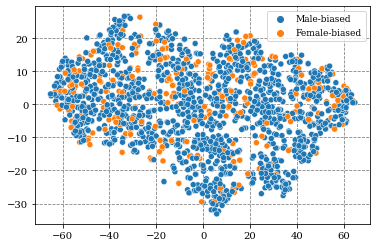

In [82]:
method="tsne"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    plt.rcParams['font.family']='Serif'
    
    if method=="pca":
        pca=PCA(n_components=2)
        M=6000
    elif method=="tsne":
        pca=TSNE(n_components=2, learning_rate="auto", init="pca")
        M=1500
        
    X_proj = pca.fit_transform(X[:M])
    ax = plt.axes()
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    ax.xaxis.grid(color='gray', linestyle='dashed')
    
    y_text = ["Female-biased" if yy == 1 else "Male-biased" for yy in y]
    plt1 = sn.scatterplot(X_proj[:, 0], X_proj[:, 1], hue=y_text[:M])
    plt.legend(fontsize=9)